In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

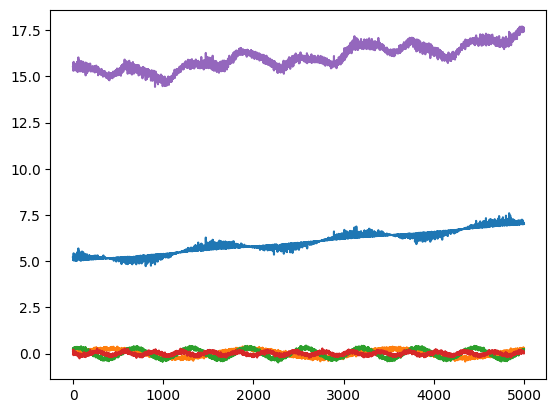

In [2]:
torch.random.manual_seed(0)

d1 = torch.ones(5000) * 5 + 0.2 * torch.cos(torch.linspace(0, 20, 5000)) * torch.randn(5000).abs() + 0.1 * torch.linspace(0, 20, 5000)
d2 = 0.25 * torch.sin(torch.linspace(0, 20, 5000)) + torch.randn(5000) * 0.05
d3 = 0.3 * torch.sin(2.5 * torch.linspace(0, 20, 5000) + 1) + torch.randn(5000) * 0.05
d4 = 0.1 * torch.cos(5 * torch.linspace(0, 20, 5000) + 1) + torch.randn(5000) * 0.05
target = d2 + d3 + d4 + (d1).abs() + 10

plt.plot(d1)
plt.plot(d2)
plt.plot(d3)
plt.plot(d4)
plt.plot(target)
plt.show()

In [3]:
X = torch.stack([d1, d2, d3, d4, target], dim=1)
y = X
print(d1[0], d2[0], d3[0], d4[0], target[0])
print(X[0], y[0])
print(X.shape, y.shape)

tensor(5.2252) tensor(-0.0108) tensor(0.2234) tensor(0.1007) tensor(15.5384)
tensor([ 5.2252e+00, -1.0811e-02,  2.2338e-01,  1.0068e-01,  1.5538e+01]) tensor([ 5.2252e+00, -1.0811e-02,  2.2338e-01,  1.0068e-01,  1.5538e+01])
torch.Size([5000, 5]) torch.Size([5000, 5])


In [4]:
n = int(0.8*len(X)) # first 80% will be train, rest val
train_data = X[:n]
val_data = X[n:]
train_target = y[:n]
val_target = y[n:]

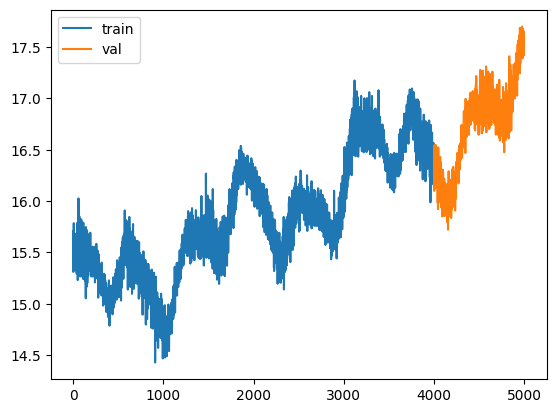

In [5]:
# plot the train and validation data
plt.plot(torch.arange(len(train_data)), train_target[:, -1], label='train')
plt.plot(torch.arange(len(train_data), len(train_data) +
         len(val_data)), val_target[:, -1], label='val')
plt.legend()
plt.show()


In [6]:
# hyperparameters
batch_size = 32 # how many independent sequences to process in parallel
block_size = 512 # what is the maximum context length for predictions?
max_iters = 100 # how many training iterations to run
eval_interval = 10 # how often to evaluate the model on the validation set
learning_rate = 1e-3 # how fast should the model learn?
device = "cuda" if torch.cuda.is_available() else "cpu" # use GPU if available
eval_iters = 10 # how many iterations to run the evaluation for
n_embd = 32 # how many dimensions to use for the embeddings
output_dim = 5
input_dim = output_dim
# ------------------------------


In [7]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    target = train_target if split == 'train' else val_target
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([target[i:i+block_size] for i in ix])
    return x, y

In [8]:
get_batch('train')[0].shape, get_batch('train')[1].shape

(torch.Size([32, 512, 5]), torch.Size([32, 512, 5]))

In [9]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:
class TimeVec(nn.Module):
    """
    Embedding of the time index
    """
    def __init__(self, time_dim):
        super().__init__()
        self.n_embd = n_embd
        self.linear_time = nn.Linear(1, time_dim)
        self.nonlinear_time = nn.Linear(1, time_dim)

    def forward(self, x):
        t = torch.arange(x.shape[1]).float() + 1 # so that t=1 corresponds to the first token
        t = t.view(1, -1, 1)
        lin_time = self.linear_time(t)
        nonlin_time = self.nonlinear_time(torch.sin(t))
        return torch.cat([lin_time, nonlin_time], dim=-1)

7381
torch.Size([32, 512, 5]) tensor(166.5602, grad_fn=<MseLossBackward0>)
torch.Size([1, 512, 5])
torch.Size([1, 612, 5])
(512,) (100,)


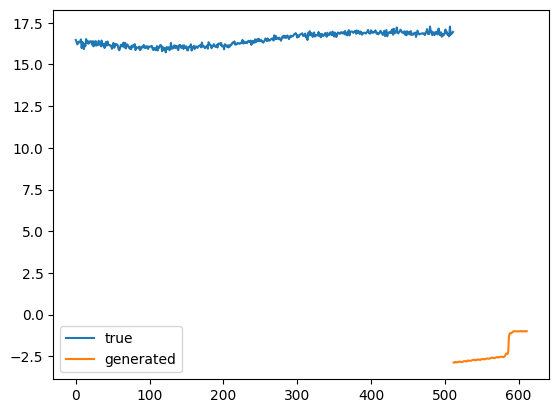

In [11]:
class Head(nn.Module):
    """
    One head of self attention
    """
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd + n_embd // 2, head_size, bias=False)
        self.key = nn.Linear(n_embd + n_embd // 2, head_size, bias=False)
        self.value = nn.Linear(n_embd + n_embd // 2, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # B, T, C
        q = self.query(x) # B, T, C
        # compute the attention scores ("affinity")
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # B, T, T
        # mask out the future tokens
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        # apply softmax to get the attention weights
        wei = wei.softmax(dim=-1) # B, T, T
        # apply the attention weights to the values
        v = self.value(x) # B, T, C
        return wei @ v # B, T, C

class MultiHeadAttention(nn.Module):
    """
    Multiple self-attention heads in parallel
    """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

class TransformerLanguageModel(nn.Module):
    """
    Model that uses Transformer blocks
    """
    def __init__(self):
        super().__init__()
        # the token embedding is replaced with a linear layer - dimensionality raiser layer
        self.raiser = nn.Linear(input_dim, n_embd) # - 1 to account for the positional index

        # positional encoding via sine and cosine
        self.time_position_encoding = TimeVec(n_embd // 4)

        # self-attention head
        self.sa_head = MultiHeadAttention((n_embd + n_embd // 2) // (n_embd // 4), n_embd // 4)

        # linear layer to project the output to the output dimension
        self.lm_head = nn.Linear(n_embd + n_embd // 2, output_dim)

        # loss is mean squared error
        self.loss = nn.MSELoss()

    def forward(self, x, targets=None):
        B, S, F = x.shape
        # B - batch size
        # S - sequence length
        # F - number of features

        # get the time positional encoding vectors
        pos = self.time_position_encoding(x) # 1, S, n_embd // 2
        # repeat the positional encoding vectors for each batch
        pos = pos.repeat(B, 1, 1) # B, S, n_embd // 2

        # raise the dimensionality of the input - this is like the token embedding
        x = self.raiser(x) # B, S, n_embd

        # add the positional encoding to the input
        x = torch.cat([x, pos], dim=-1) # B, S, n_embd + n_embd // 2
        x = self.sa_head(x) # B, S, n_embd + n_embd // 2 
        logits = self.lm_head(x) # B, S, output_dim

        if targets is not None:
            loss = self.loss(logits, targets)
        else:
            loss = None
        return logits, loss

    def generate(self, in_sample, max_new_tokens):
        # in_sample has shape (B, S, F)
        for _ in range(max_new_tokens):
            # crop in to the last block_size tokens
            in_cond = in_sample[:, -block_size:] # (B, S, F)
            # get the predictions
            logits, loss = self(in_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, input_dim)
            # append the sampled in to the running sequence
            in_sample = torch.hstack([in_sample, logits.unsqueeze(1)])
        return in_sample

m = TransformerLanguageModel()
print(sum(p.numel() for p in m.parameters()))
x, y = get_batch('train')
logits, loss = m(x, y)
print(logits.shape, loss)


# generate some outputs
in_sample = get_batch('val')[0][0].unsqueeze(0) # take the first batch element and add a batch dimension
print(in_sample.shape)
gen_n = 100
gen = m.generate(in_sample, gen_n)
print(gen.shape)
logits_true = gen[0, :(gen.shape[1] - gen_n), -1].detach().view(-1).numpy()
logits_gen = gen[0, -gen_n:, -1].detach().view(-1).numpy()
true_seq = torch.arange(gen.shape[1] - gen_n).detach().numpy()
gen_seq = torch.arange(gen.shape[1] - gen_n, gen.shape[1]).detach().numpy()
print(logits_true.shape, logits_gen.shape)

# plot the true and generated sequences
plt.plot(true_seq, logits_true, label='true')
plt.plot(gen_seq, logits_gen, label='generated')
plt.legend()
plt.show()

In [12]:
# lets see if training works
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(m)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    
    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 166.6478, val loss 174.8884
step 10: train loss 28.3941, val loss 33.4065
step 20: train loss 6.7079, val loss 8.4395
step 30: train loss 0.4589, val loss 0.4439
step 40: train loss 0.6825, val loss 0.5262
step 50: train loss 0.2949, val loss 0.4049
step 60: train loss 0.0845, val loss 0.2766
step 70: train loss 0.1037, val loss 0.2125
step 80: train loss 0.0706, val loss 0.1606
step 90: train loss 0.0704, val loss 0.1859
step 99: train loss 0.0715, val loss 0.1772


torch.Size([1, 512, 5])
torch.Size([1, 612, 5])
(512,) (100,)


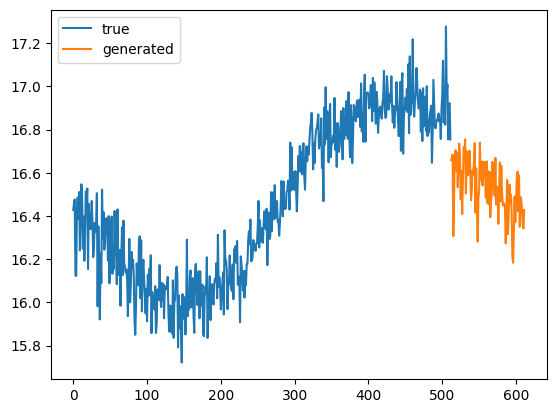

In [14]:
# generate some outputs
in_sample = get_batch('val')[0][0].unsqueeze(0) # take the first batch element and add a batch dimension
print(in_sample.shape)
gen_n = 100
gen = m.generate(in_sample, gen_n)
print(gen.shape)
logits_true = gen[0, :(gen.shape[1] - gen_n), -1].detach().view(-1).numpy()
logits_gen = gen[0, -gen_n:, -1].detach().view(-1).numpy()
true_seq = torch.arange(gen.shape[1] - gen_n).detach().numpy()
gen_seq = torch.arange(gen.shape[1] - gen_n, gen.shape[1]).detach().numpy()
print(logits_true.shape, logits_gen.shape)

# plot the true and generated sequences
plt.plot(true_seq, logits_true, label='true')
plt.plot(gen_seq, logits_gen, label='generated')
plt.legend()
plt.show()